<a href="https://colab.research.google.com/github/danchaud-vincent/tensorflow-deep-learning/blob/main/05_Transfer_learning_in_tensorflow_part2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ of pre-trained model.

![](https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)

# What we're going to cover

We're going to go through the follow with TensorFlow:
- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data.
- Using the Keras Functional API (a different way to build models in Keras)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- Data augmentation (how to make your training dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data:
  - Model 0: a transfer learning model using Keras Functional API
  - Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
  - Model 2 : a feature extraction transfer learning model on 10 % of the data with data augmentation
  - Model 3: a fine-tuned transfer learning model on 10% of the data
  - Model 4: a fine-tuned transfer learning model on 100% of the data
- Introduce the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard

In [1]:
# Using a GPU?
!nvidia-smi

Tue Oct  4 14:34:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

Throughout your machine learning experiments, you'll likely come accross snippets of code you want to use over and over again.

For example, a plotting function which plots a model's `history` object (see `plot_loss_curves()` below).

You could recreate these functions over and over again. But as you might have guessed, rewritting the same functions becomes tedious.

One of the solutions is to store them in a helper functions script such as `helper_functions.py`. And then import the necessary functionality when you need it.


Let's see what this looks like.

In [53]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/utils/helper_functions.py 

--2022-10-04 15:34:25--  https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/utils/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2600 (2.5K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.54K  --.-KB/s    in 0s      

2022-10-04 15:34:25 (43.1 MB/s) - ‘helper_functions.py’ saved [2600/2600]



In [63]:
# import Helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir, unzip_data

### 1O Food Classes: Working with less data

We saw in the previous notebook that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the `tf.keras.applications` module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, `image_dataset_from_directory()` which is part of the `tf.keras.preprocessing` module.

Finally, we'll also be practicing using the [`Keras Functional API`](https://keras.io/guides/functional_api/) for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.

In [4]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-10-04 14:34:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  42.9MB/s    in 3.8s    

2022-10-04 14:34:35 (42.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# unzip the data
unzip_data("/content/10_food_classes_10_percent.zip")

In [6]:
# walkthrough the directories
walk_through_dir("/content/10_food_classes_10_percent")

/content/10_food_classes_10_percent: There are 2 directories and 0 files
/content/10_food_classes_10_percent/test: There are 10 directories and 0 files
/content/10_food_classes_10_percent/test/grilled_salmon: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/hamburger: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/steak: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/chicken_curry: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/pizza: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/chicken_wings: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/ramen: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/ice_cream: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/fried_rice: There are 0 directories and 250 files
/content/10_food_classes_10_percent/

In [7]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously we've used the `ImageDataGenerator` class. And while this works well and is still very commonly used, this time we're going to use the `image_data_from_directory` function.

It works much the same way as `ImageDataGenerator`'s `flow_from_directory` method meaning your images need to be in the following file format:

Example of file structure:
10_food_classes_10_percent <- top level folder
└───train <- training images 
│   │   │     
│   └───pizza
    
│- - - - -  1008104.jpg'

│- - - - -  1638227.jpg
 
│- - - - -  ...      
│   └───steak

│- - - - -  1000205.jpg

│- - - - -  1647351.jpg

│- - - - -   ...
      
└───test <- testing images

│   └───pizza

│- - - - -  1001116.jpg

│- - - - -  1507019.jpg

│- - - - -  ...      

│   └───steak

│- - - - -  100274.jpg

│- - - - -  1653815.jpg

│- - - - -  ...   

One of the main benefits of using `tf.keras.preprocessing.image_dataset_from_directory()` rather than `ImageDataGenerator` is that it creates a `tf.data.Dataset` object rather than a generator. The main advantage of this is the `tf.data.Dataset` API is much more efficient (faster) than the `ImageDataGenerator` API which is paramount for larger datasets.



In [8]:
# Create data inputs

import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=BATCH_SIZE) # batch_size is 32 by default, this is generally a good number

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)                                                                         

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


It looks like our dataloaders have found the correct number of images for each dataset.

For now, the main parameters we're concerned about in the `image_dataset_from_directory()` function are:
- `directory` - the filepath of the target directory we're loading images in from.
- `image_size` - the target size of the images we're going to load in (height, width).
- `batch_size` - the batch size of the images we're going to load in. For example if the batch_size is 32 (the default), batches of 32 images and labels at a time will be passed to the model.

In [9]:
# Check the training data datatype
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the above output:
- `(None, 224, 224, 3)` refers to the tensor shape of our images where `None` is the batch size, `224` is the height (and width) and `3` is the color channel (red, green blue).
- `(None, 10)` refers to the tensor shape of the labels where `None` is the batch size and `10` is the number of possible labels (the 10 different food classes).
- Both image tensors and labels are of the datatype `tf.float32`.

The `batch_size` is `None` due to it only being used during model training. You can think `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

Another benefit of using `tf.data.Dataset` API are the associated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the `class_names` attribute.

In [10]:
# get the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of batch of data
train_data_10_percent.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [12]:
for images, labels in train_data_10_percent.take(1):
  print(images)
  print(labels)

tf.Tensor(
[[[[1.19751595e+02 1.07751595e+02 1.07751595e+02]
   [1.21745537e+02 1.09745537e+02 1.09745537e+02]
   [1.23039223e+02 1.11039223e+02 1.11039223e+02]
   ...
   [7.90090561e+01 6.30090599e+01 6.37947960e+01]
   [9.00227356e+01 7.50227356e+01 7.80227356e+01]
   [7.74074249e+01 6.54074249e+01 6.94074249e+01]]

  [[1.19937180e+02 1.07937180e+02 1.07937180e+02]
   [1.20967796e+02 1.08967796e+02 1.08967796e+02]
   [1.23096619e+02 1.11096619e+02 1.11096619e+02]
   ...
   [9.75188370e+01 8.15188370e+01 8.23045731e+01]
   [8.44631042e+01 6.94631042e+01 7.24631042e+01]
   [8.47994003e+01 7.27994003e+01 7.67994003e+01]]

  [[1.20084824e+02 1.08084824e+02 1.08084824e+02]
   [1.20084824e+02 1.08084824e+02 1.08084824e+02]
   [1.23196114e+02 1.11196114e+02 1.11196114e+02]
   ...
   [8.48886642e+01 6.88886642e+01 6.96744003e+01]
   [9.36168823e+01 7.86168823e+01 8.16168823e+01]
   [7.25082703e+01 6.05082703e+01 6.45082703e+01]]

  ...

  [[7.52982254e+01 6.92982254e+01 7.92982254e+01]
   [7

Notice how the image arrays come out as tensors of pixel values where as the labels come out as one-hot encodings (e.g. `[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]` for `hamburger`)

### Model 0: Building a transfer learning model using the Keras Functional API

Let's build a model.

To do so we're going to be using the `tf.keras.applications` module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as `EfficientNetB0` from `tf.keras.applications`, setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's `trainable` attribute to `False` to freeze all the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as `ResNetV250` require their inputs to be between 0 & 1.
> **Note :** As of writing, the `EfficientNetB0` models in `tf.keras.applications` module do not require images to be normalized on input, where as many of the other models do. 

5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using `tf.keras.layers.GlobalAveragePooling2D()` or `tf.keras.layers.GlobalMaxPooling2D()` though the former is more common in practice).
7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using `tf.keras.Model()`
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks.

In [37]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,), name='inputLayer')

# 4. If using a model like ResNet50V2 you will need to normalize inputs 
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(len(train_data_10_percent.class_names), activation="softmax", name="outputLayer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [38]:
# Compile our model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [39]:
# fit our model
history_model0 = model_0.fit(train_data_10_percent,
                             epochs=5,
                             steps_per_epoch=len(train_data_10_percent),
                             validation_data=test_data_10_percent,
                             validation_steps=int(0.25*len(test_data_10_percent)), # validate on only 25% of test_data (validate quicker)
                             callbacks=[create_tensorboard_callback("transfer_learning","10_percent_feature_extract")])

Saving TensorBoard log files to :transfer_learning/10_percent_feature_extract/2022-10-04_15:25:26
Epoch 1/5
24/24 [==============================] - 11s 213ms/step - loss: 1.9215 - accuracy: 0.3893 - val_loss: 1.3509 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 4s 156ms/step - loss: 1.1639 - accuracy: 0.7360 - val_loss: 0.9305 - val_accuracy: 0.7993
Epoch 3/5
24/24 [==============================] - 5s 188ms/step - loss: 0.8550 - accuracy: 0.8040 - val_loss: 0.7669 - val_accuracy: 0.8289
Epoch 4/5
24/24 [==============================] - 4s 152ms/step - loss: 0.6964 - accuracy: 0.8400 - val_loss: 0.6721 - val_accuracy: 0.8454
Epoch 5/5
24/24 [==============================] - 5s 186ms/step - loss: 0.6088 - accuracy: 0.8587 - val_loss: 0.6065 - val_accuracy: 0.8520


In [40]:
# Evaluate on the full test dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 74ms/step - loss: 0.6182 - accuracy: 0.8368


[0.6181545257568359, 0.8367999792098999]

After a minute or so of training our model performs incredibly well on the training and test sets. 

It's important to note the kind of transfer learning we used here is called **feature extraction** transfer learning, similar to what we did with the TensorFlow Hub models.

In other words, we passed our custom data to an already pre-trained model (`EfficientNetB0`), asked it "what patterns do you see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of classes.

We also used the Keras Functional API to build our model rather than the Sequential API. For now, the benefits of this main not seem clear but when you start to build more sophisticated models, you'll probably want to use the Functional API. So it's important to have exposure to this way of building models.

In [41]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_4
1 rescaling_3
2 normalization_3
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [42]:
# summary of the base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_3 (Rescaling)        (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_3 (Normalization  (None, None, None,   7          ['rescaling_3[0][0]']            
 )                              3)                                                   

In [43]:
# summary of the model
model_0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 outputLayer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


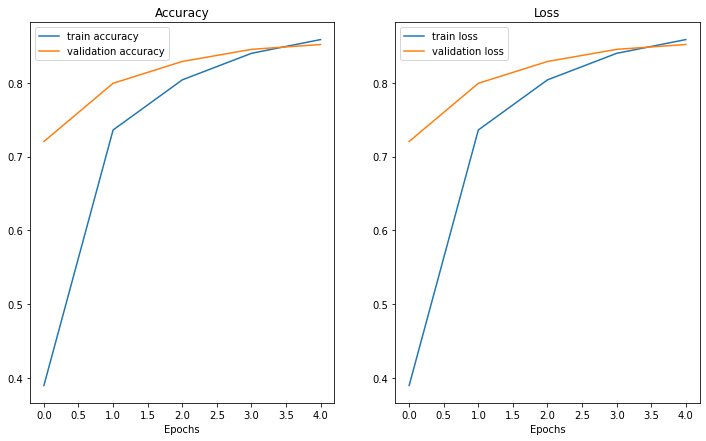

In [67]:
# Check out our model's training curves
plot_loss_curves(history_model0)